# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
# %pip install tqdm sklearn pandas

In [20]:
from utils import get_dataset
from math import ceil
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import collections
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import glob, os
import shutil

In [3]:
%matplotlib inline

In [4]:
dataset = get_dataset("/waymo/processed/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 100
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [5]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    size = len(list(batch))
    rows = ceil(size / 2)
    
    fig = plt.figure(figsize=(12., 12 * rows))
    grid = ImageGrid(
        fig, 
        111,  
        nrows_ncols=(rows, 2), 
        axes_pad=0.1, 
    )
    
    colormap = {
        1: [0, 0, 1], 
        2: [0, 1, 0], 
        4: [1, 0, 0]
    }

    for ax, im in zip(grid, batch):
        image = im["image"].numpy()
        image_size_x = image.shape[1]
        image_size_y = image.shape[0]
        
        ax.imshow(image)
        
        for bbox, label in zip(im['groundtruth_boxes'], im['groundtruth_classes']):
            bbox = bbox.numpy()
            label = label.numpy()
            x1 = bbox[1]
            x2 = bbox[3]
            y1 = bbox[0]
            y2 = bbox[2]
            rect = patches.Rectangle(
                (x1 * image_size_x, y1 * image_size_y), 
                (x2 - x1) * image_size_x, 
                (y2 - y1) * image_size_y, 
                linewidth=1, 
                edgecolor=colormap[label], 
                facecolor='none'
            )
            ax.add_patch(rect)


    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

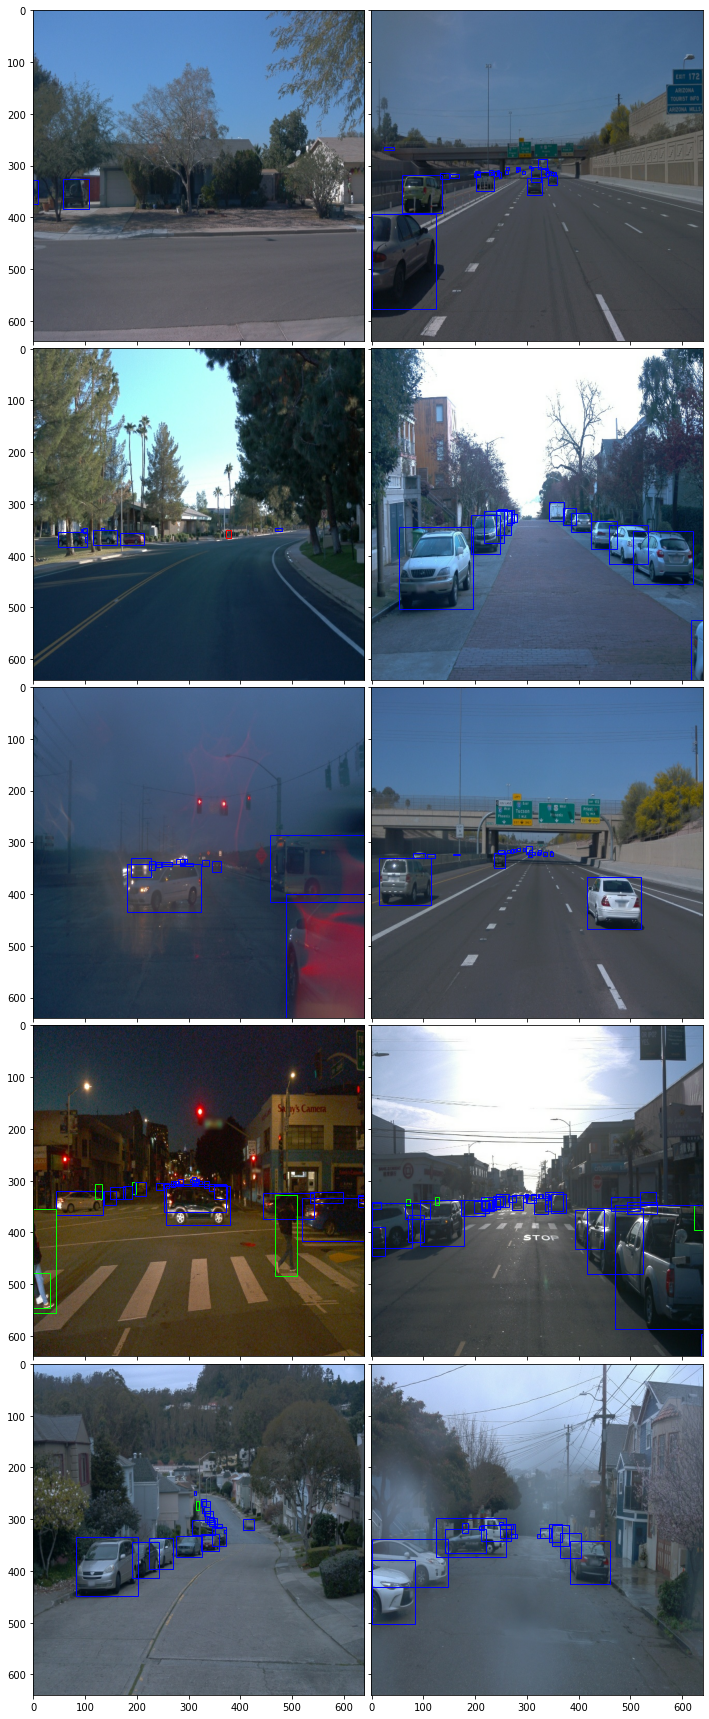

In [6]:
## STUDENT SOLUTION HERE
display_instances(dataset.shuffle(100).take(10))

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [7]:
def calculate_label_distro(dataset):
    co = collections.Counter()
    for row in dataset:
        co.update(row["groundtruth_classes"].numpy())
    return co    

def get_distros(path):
    distros = {}
    for data_file in tqdm(glob.glob(path)):
        df = get_dataset(data_file).take(1000)
        co = calculate_label_distro(df)
        distros[data_file] = co

    return pd.DataFrame({x: dict(distros[x].items()) for x in distros}).T.fillna(0)

def add_has_value_column(df):
    ret = pd.DataFrame()
    for col in df.columns:
        ret[f"has_{col}"] = (df[col] > 0.0).astype("category")
    return ret

def merge_categorical_columns(df):
    return df.apply(lambda x: " ".join(x.astype(str)), axis=1).astype('category')

def prepare_split_files(path):
    df = get_distros(path)
    dd = merge_categorical_columns(add_has_value_column(df))
    dataset_train, dataset_test = train_test_split(dd.cat.codes, stratify=dd.cat.codes.values, test_size=0.1, random_state=1)
    dataset_train, dataset_val = train_test_split(dataset_train, stratify=dataset_train.values, test_size=0.11, random_state=1)
    return dataset_train, dataset_test, dataset_val

In [8]:
dataset_train, dataset_test, dataset_val = prepare_split_files("/waymo/processed/*.tfrecord")

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10723911392655396041_860_000_880_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10723911392655396041_860_000_880_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filen

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10498013744573185290_1240_000_1260_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10498013744573185290_1240_000_1260_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10275144660749673822_5755_561_5775_561_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10275144660749673822_5755_561_5775_561_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11119453952284076633_1369_940_1389_940_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11119453952284076633_1369_940_1389_940_with_camer

INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10964956617027590844_1584_680_1604_680_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10625026498155904401_200_000_220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10625026498155904401_200_000_220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11674150664140226235_680_000_700_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11674150664140226235_680_000_700_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10231929575853664160_1160_000_1180_000_with_camera_labels

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11076364019363412893_1711_000_1731_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11076364019363412893_1711_000_1731_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord']
INFO:tensorflow:Number of f

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10023947602400723454_1120_000_1140_000_with_camer

INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10770759614217273359_1465_000_1485_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1


In [1]:
# show label distribution

In [9]:
dataset_train.value_counts() / dataset_train.sum()

2    0.272059
0    0.154412
3    0.147059
1    0.014706
dtype: float64

In [10]:
len(dataset_train)

80

In [11]:
dataset_test.value_counts() / dataset_test.sum()

2    0.3125
0    0.1875
3    0.1250
dtype: float64

In [12]:
len(dataset_test)

10

In [13]:
dataset_val.value_counts() / dataset_val.sum()

2    0.263158
3    0.157895
0    0.105263
dtype: float64

In [14]:
len(dataset_val)

10